# Fasttext+GRU/LSTM/CNN

# データの読み込み

In [6]:
import os
os.listdir()

['.ipynb_checkpoints',
 'Code',
 'crawl-300d-2M.vec',
 'desktop.ini',
 'FastText+GRU.ipynb',
 'Kaggle Driver Detection 手法説明.pptx',
 'neural_network_console_150',
 'sample_submission.csv',
 'submission.csv',
 'test.csv',
 'train.csv',
 'VNC Viewer.lnk',
 '~$Kaggle Driver Detection 手法説明.pptx',
 '⑤ラズパイ環境構築.pptx',
 'アンケート提出先 (192.168.1.87) - ショートカット.lnk',
 'ナイーブベイズ.ipynb',
 '教えないラズパイ実装講座 (192.168.1.87) - ショートカット.lnk',
 '講義資料']

In [10]:
import numpy as np
np.random.seed(42)
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from keras.models import Model
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, concatenate
from keras.layers import GRU, LSTM, RNN, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.preprocessing import text, sequence
from keras.callbacks import Callback

#ファイル名を指定
EMBEDDING_FILE = 'crawl-300d-2M.vec'

#データ読み込み
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

#データ作成
X_train = train["comment_text"].fillna("fillna").values
y_train = train[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values
X_test = test["comment_text"].fillna("fillna").values

#パラメータ設定
max_features = 30000 #頻度の高い30000語をトークン化、そこに入っていない単語には0が与えられる
maxlen = 201 #学習させる文章の単語数
embed_size = 300 #分散表現の次元

In [11]:
#tokenizerでトークン化
tokenizer = text.Tokenizer(num_words=max_features,lower=False,filters='"#$%&()*+,-./:;<=>@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(list(X_train) + list(X_test))
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

#長さを調整
x_train = sequence.pad_sequences(X_train, maxlen=maxlen)
x_test = sequence.pad_sequences(X_test, maxlen=maxlen)

100%|█████████████████████████████████████████████████████████████████████| 159571/159571 [00:00<00:00, 1950405.02it/s]


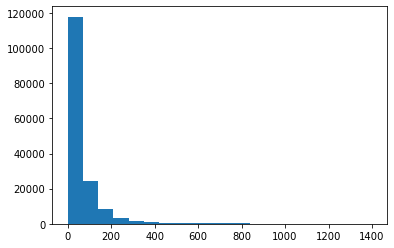

In [14]:
#1文章に入る単語の数を確認
from tqdm import tqdm
len_list=[]
for i in tqdm(range(len(X_train))):
    len_list.append(len(X_train[i]))
    
#可視化
import numpy as np
import matplotlib.pyplot as plt
plt.hist(np.array(len_list),bins=20)
plt.show()

# embedding_matrix作成

In [15]:
#FastTextによる分散表現を読み込み
def get_coefs(word, *arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE,encoding="utf-8"))

In [16]:
#word_index は {the:1} 等の辞書形式
word_index = tokenizer.word_index

#結果を格納する箱を作成
nb_words = min(max_features, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_size)) #30000×300の配列を作成

#30000以下の単語の分散表現を格納する
#もしない場合は0のまま
for word, i in tqdm(word_index.items()):
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

100%|█████████████████████████████████████████████████████████████████████| 512722/512722 [00:00<00:00, 1553162.52it/s]


In [17]:
word_index

{'the': 1,
 'to': 2,
 'of': 3,
 'and': 4,
 'a': 5,
 'I': 6,
 'is': 7,
 'you': 8,
 'that': 9,
 'in': 10,
 'it': 11,
 'for': 12,
 'not': 13,
 'on': 14,
 'be': 15,
 'this': 16,
 'as': 17,
 'have': 18,
 'are': 19,
 'with': 20,
 'your': 21,
 'article': 22,
 'was': 23,
 'or': 24,
 'but': 25,
 'The': 26,
 'an': 27,
 'page': 28,
 'from': 29,
 'by': 30,
 'at': 31,
 'my': 32,
 'about': 33,
 'do': 34,
 'if': 35,
 'Wikipedia': 36,
 'me': 37,
 'can': 38,
 'has': 39,
 'so': 40,
 'would': 41,
 'all': 42,
 'like': 43,
 'will': 44,
 'one': 45,
 'what': 46,
 'If': 47,
 'just': 48,
 'there': 49,
 'which': 50,
 'they': 51,
 'been': 52,
 'should': 53,
 'any': 54,
 'no': 55,
 'more': 56,
 'You': 57,
 'talk': 58,
 "don't": 59,
 'other': 60,
 'some': 61,
 'he': 62,
 'think': 63,
 'who': 64,
 'we': 65,
 'his': 66,
 'see': 67,
 'here': 68,
 "I'm": 69,
 'know': 70,
 'up': 71,
 'It': 72,
 'This': 73,
 'because': 74,
 'people': 75,
 'out': 76,
 'only': 77,
 'edit': 78,
 'use': 79,
 'Please': 80,
 'also': 81,
 'am'

# モデル作成(GRU)

In [18]:
#AUCを評価するためのクラスを定義する
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__() #Callbackのinitメソッドを呼び出し

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        #intervalで割り切れるエポックの時のみ
        if epoch % self.interval == 0:
            #validationデータを評価して、AUCを出力する
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))

In [25]:
#モデル作成
def get_model():
    inp = Input(shape=(maxlen, ))
    #30000×300
    #weightにfasttext結果を指定
    #trainable=Falseで学習させない
    x = Embedding(max_features, embed_size, weights=[embedding_matrix],trainable=True)(inp)
    
    #SpatialDropoutはある次元を丸ごと落とす処理
    #https://hironsan.hatenablog.com/entry/keras-spatial-dropout
    x = SpatialDropout1D(0.2)(x)
    
    #Bidirectionalは単語を右から読むのと、左から読むもの
    x = Bidirectional(GRU(80, return_sequences=True))(x)
    
    #ave_poolとmax_poolを行ってconcat
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    
    #output層を作成
    outp = Dense(6, activation="sigmoid")(conc)
    
    #compile
    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

model = get_model()

In [26]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 201)          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 201, 300)     9000000     input_2[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_2 (SpatialDro (None, 201, 300)     0           embedding_2[0][0]                
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 201, 160)     182880      spatial_dropout1d_2[0][0]        
____________________________________________________________________________________________

In [27]:
#学習パラメータの指定
batch_size = 32
epochs = 2

#データを分割
X_tra, X_val, y_tra, y_val = train_test_split(x_train, y_train, train_size=0.95, random_state=233)

#AUCクラスをインスタンス化
RocAuc = RocAucEvaluation(validation_data=(X_val, y_val), interval=1)
#学習
hist = model.fit(X_tra, y_tra, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val),
                 callbacks=[RocAuc], verbose=1)

#予測
y_pred = model.predict(x_test, batch_size=1024)
submission[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]] = y_pred
submission.to_csv('submission.csv', index=False)

Train on 151592 samples, validate on 7979 samples
Epoch 1/2
151592/151592 [==============================] - 3405s 22ms/step - loss: 0.0524 - acc: 0.9813 - val_loss: 0.0470 - val_acc: 0.9820

 ROC-AUC - epoch: 1 - score: 0.985814 

Epoch 2/2
151592/151592 [==============================] - 69451s 458ms/step - loss: 0.0389 - acc: 0.9850 - val_loss: 0.0461 - val_acc: 0.9822

 ROC-AUC - epoch: 2 - score: 0.985882 



# モデル作成(LSTM)

In [29]:
from keras.layers import LSTM

#モデル作成
def get_model():
    inp = Input(shape=(maxlen, ))
    #30000×300
    #weightにfasttext結果を指定
    #trainable=Falseで学習させない
    x = Embedding(max_features, embed_size, weights=[embedding_matrix],trainable=True)(inp)
    
    #SpatialDropoutはある次元を丸ごと落とす処理
    #https://hironsan.hatenablog.com/entry/keras-spatial-dropout
    x = SpatialDropout1D(0.2)(x)
    
    #Bidirectionalは単語を右から読むのと、左から読むもの
    x = Bidirectional(LSTM(80, return_sequences=True))(x)
    
    #ave_poolとmax_poolを行ってconcat
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    
    #output層を作成
    outp = Dense(6, activation="sigmoid")(conc)
    
    #compile
    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

model = get_model()

In [30]:
#学習パラメータの指定
batch_size = 32
epochs = 2

#データを分割
X_tra, X_val, y_tra, y_val = train_test_split(x_train, y_train, train_size=0.95, random_state=333)

#AUCクラスをインスタンス化
RocAuc = RocAucEvaluation(validation_data=(X_val, y_val), interval=1)
#学習
hist = model.fit(X_tra, y_tra, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val),
                 callbacks=[RocAuc], verbose=1)

#予測
y_pred = model.predict(x_test, batch_size=1024)
submission[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]] = y_pred
submission.to_csv('submission1.csv', index=False)

Train on 151592 samples, validate on 7979 samples
Epoch 1/2
151592/151592 [==============================] - 4420s 29ms/step - loss: 0.0547 - acc: 0.9808 - val_loss: 0.0441 - val_acc: 0.9839

 ROC-AUC - epoch: 1 - score: 0.984180 

Epoch 2/2
151592/151592 [==============================] - 4765s 31ms/step - loss: 0.0398 - acc: 0.9847 - val_loss: 0.0452 - val_acc: 0.9831

 ROC-AUC - epoch: 2 - score: 0.985588 



# モデル作成(CNN)

In [33]:
from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding

def get_model():
    inp = Input(shape=(maxlen, ))
    #30000×300
    #weightにfasttext結果を指定
    #trainable=Falseで学習させない
    embedded_sequences = Embedding(max_features, embed_size, weights=[embedding_matrix],trainable=True)(inp)

    # Yoon Kim model (https://arxiv.org/abs/1408.5882)
    convs = []
    filter_sizes = [3,4,5]

    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=128, kernel_size=filter_size, activation='relu',padding='same')(embedded_sequences)
        l_pool = MaxPooling1D(pool_size=3)(l_conv)
        convs.append(l_pool)

    l_merge = concatenate(convs)

    # add a 1D convnet with global maxpooling, instead of Yoon Kim model
    conv = Conv1D(filters=128, kernel_size=3, activation='relu')(embedded_sequences)
    pool = MaxPooling1D(pool_size=3)(conv)
   
    x = Dropout(0.5)(l_merge)  
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    #output層を作成
    outp = Dense(6, activation="sigmoid")(x)
    
    #compile
    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    model.summary()
    return model

model = get_model()


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 201)          0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 201, 300)     9000000     input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 201, 128)     115328      embedding_4[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 201, 128)     153728      embedding_4[0][0]                
___________________________________________________________________________________________

In [34]:
#学習パラメータの指定
batch_size = 32
epochs = 1

#データを分割
X_tra, X_val, y_tra, y_val = train_test_split(x_train, y_train, train_size=0.95, random_state=333)

#AUCクラスをインスタンス化
RocAuc = RocAucEvaluation(validation_data=(X_val, y_val), interval=1)
#学習
hist = model.fit(X_tra, y_tra, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val),
                 callbacks=[RocAuc], verbose=1)

#予測
y_pred = model.predict(x_test, batch_size=1024)
submission[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]] = y_pred
submission.to_csv('submission2.csv', index=False)

Train on 151592 samples, validate on 7979 samples
Epoch 1/1
151592/151592 [==============================] - 219s 1ms/step - loss: 0.0729 - acc: 0.9759 - val_loss: 0.0524 - val_acc: 0.9815

 ROC-AUC - epoch: 1 - score: 0.974310 

